### This Jupyter notebook contains the code used to generate Supplementary Figure 10. 

The analysis computes ratios of PTM-containing peptides to unmodified peptides from the same protein and plots these ratios against protein abundance. 

##### Dependencies: 
1. 'Main_Proteins_to_Peptides_map.p' for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline)
2. 'main_peptide_precursor_quant_df.xlsx' for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline). Healthy data file name is 'main_peptide_quant_df.xlsx'.
3. 'Main_protein_precursor_quant_df_medianpeptide.xlsx' for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline).
4. 'DP_search_evidence_dict.p' for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline).

In [6]:
# read in packages needed
# install any missing packages using conda or pip 

import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from collections import Counter
import scipy as sp
from copy import deepcopy
from statsmodels.stats.multitest import multipletests
#from adjustText import adjust_text
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
import os
from glob import glob
import warnings
import random

In [2]:
proj_dir = 'Code_for_figures_testing/'

#proj_dir = os.getcwd()+'/'
dependencies_dir = proj_dir+'pipeline_output/analysis_dependencies/'
outdir = proj_dir+'figures_testing/' # output directory where to save figures

# [dataset]_aa_subs_dir is the decode pipeline output folder
ccrcc_proj_dir = dependencies_dir+'CCRCC/'
ccrcc_aa_subs_dir = ccrcc_proj_dir+'AA_subs_pipeline/'
ccrcc_sample_map = pd.read_excel(ccrcc_aa_subs_dir+'sample_map.xlsx')
ccrcc_samples = ['S'+str(i) for i in list(set(ccrcc_sample_map['TMT plex']))]

ucec_proj_dir = dependencies_dir+'UCEC/'
ucec_aa_subs_dir = ucec_proj_dir+'AA_subs_pipeline/'
ucec_sample_map = pd.read_excel(ucec_aa_subs_dir+'sample_map.xlsx')
ucec_samples = ['S'+str(i) for i in list(set(ucec_sample_map['TMT plex']))]

brca_proj_dir = dependencies_dir+'BRCA/'
brca_aa_subs_dir = brca_proj_dir+'AA_subs_pipeline/'
brca_sample_map = pd.read_excel(brca_aa_subs_dir+'sample_map.xlsx')
brca_samples = ['S'+str(i) for i in list(set(brca_sample_map['TMT plex']))]

luad_proj_dir = dependencies_dir+'LUAD/'
luad_aa_subs_dir = luad_proj_dir+'AA_subs_pipeline/'
luad_sample_map = pd.read_excel(luad_aa_subs_dir+'sample_map.xlsx')
luad_samples = ['S'+str(i) for i in list(set(luad_sample_map['TMT plex']))]

pdac_proj_dir = dependencies_dir+'PDAC/'
pdac_aa_subs_dir = pdac_proj_dir+'AA_subs_pipeline/'
pdac_sample_map = pd.read_excel(pdac_aa_subs_dir+'sample_map.xlsx')
pdac_samples = ['S'+str(i) for i in list(set(pdac_sample_map['TMT plex']))]

lscc_proj_dir = dependencies_dir+'LSCC/'
lscc_aa_subs_dir = lscc_proj_dir+'AA_subs_pipeline/'
lscc_sample_map = pd.read_excel(lscc_aa_subs_dir+'sample_map.xlsx')
lscc_samples = ['S'+str(i) for i in list(set(lscc_sample_map['TMT plex']))]

wang_proj_dir = dependencies_dir+'HealthyTissues/'
wang_data_dir = wang_proj_dir+'AA_subs_pipeline/'
wang_samples = open(wang_data_dir+'proteomic_tissue_list.txt', 'r').read().split('\n')
wang_samples = [x for x in wang_samples if x!='rectum']

# lists used to quickly index dataset-specific sample maps (e.g.) from just the dataset name
datasets = ['CCRCC', 'UCEC', 'BRCA', 'LUAD', 'PDAC', 'LSCC', 'Healthy']
data_dir_list = [ccrcc_aa_subs_dir, ucec_aa_subs_dir, brca_aa_subs_dir, luad_aa_subs_dir, pdac_aa_subs_dir, lscc_aa_subs_dir, wang_data_dir]
samples_list = [ccrcc_samples, ucec_samples, brca_samples, luad_samples, pdac_samples, lscc_samples, wang_samples]
sample_map_list = [ccrcc_sample_map, ucec_sample_map, brca_sample_map, luad_sample_map, pdac_sample_map, lscc_sample_map]
proj_dir_list = [ccrcc_proj_dir, ucec_proj_dir, brca_proj_dir, luad_proj_dir, pdac_proj_dir, lscc_proj_dir, wang_proj_dir]

#### Supplementary Figure 10a

In [ ]:
warnings.filterwarnings('ignore')

# generate a dictionary containing the abundance of peptides with oxidized methionines, the abundances of the unmodified versions of the same peptide, and the protein abundance
all_ds_metox_dict = {ds:{} for ds in datasets}

for ds in datasets:
    print(ds)
    data_dir = data_dir_list[datasets.index(ds)]
    samples = samples_list[datasets.index(ds)]
    ev_dict = pickle.load(open(data_dir+'DP_search_evidence_dict.p', 'rb'))

    prot_mainpep_map = pickle.load(open(data_dir+'Main_Proteins_to_Peptides_map.p', 'rb'))
    if ds=='Healthy':
        mainpep_df = pd.read_excel(data_dir+'main_peptide_quant_df.xlsx', index_col=0)
    else:
        mainpep_df = pd.read_excel(data_dir+'main_peptide_precursor_quant_df.xlsx', index_col=0)
    mainpep_df.replace(0,np.nan, inplace=True)
    mainprot_df = pd.read_excel(data_dir+'Main_protein_precursor_quant_df_medianpeptide.xlsx', index_col=0)

    pep_dict = {s:{row['Sequence']:row['Proteins'] for i,row in s_ev.iterrows()} for s, s_ev in ev_dict.items()}

    metox_dict = {s:{} for s in samples}
    for s in samples:
        print(s)
        s_dict = ev_dict[s]
        mods = s_dict['Modifications'].to_list()
        ox_idx = [i for i,x in enumerate(mods) if 'Oxidation (M)' in x]

        ox_df = s_dict.iloc[ox_idx]
        ox_df.reset_index(inplace=True)
        unmod_df = s_dict.loc[s_dict['Modifications']=='Unmodified']
        
        ratios = []
        for i,row in ox_df.iterrows():
            seq = row['Sequence']
            ox_int = row['Intensity']
            seq_df = unmod_df.loc[unmod_df['Sequence']==seq]

            if len(seq_df)>0:
                nonmod_int = np.nansum(seq_df['Intensity'])
                ratio = ox_int/nonmod_int
                if ~np.isnan(ratio):
                    metox_dict[s][seq] = {'Intensity':ox_int, 'Unmodified_intensity':nonmod_int, 'Ratio':ratio}

        s_pep_dict = pep_dict[s]
        
       # print(len(metox_dict[s]))
        for p, pdict in metox_dict[s].items():
            if p in s_pep_dict:
                prots = s_pep_dict[p]
                if isinstance(prots, str):
                    prots = prots.split(';')
                    if isinstance(prots,list) and len(prots)>0:
                        metox_dict[s][p]['Proteins'] = prots
                    
                        prot_quant = [float(mainprot_df.loc[prot,s]) if prot in mainprot_df.index else np.nan for prot in prots]
                        metox_dict[s][p]['Medianpep_protein_quant'] = prot_quant
                        metox_dict[s][p]['Mean_medianpep_protein_quant'] = float(np.nanmean(prot_quant))

                        shared_peps_dict = {prot:list(set(prot_mainpep_map[s][prot])) for prot in prots if prot in prot_mainpep_map[s]}
                        n_prots = len(shared_peps_dict)

                        shared_peps_list = [x for y in list(shared_peps_dict.values()) for x in y]
                        shared_peps_count = Counter(shared_peps_list)
                        shared_peps = [x for x in shared_peps_list if shared_peps_count[x] == n_prots]
                        metox_dict[s][p]['Shared_peptides'] = shared_peps

                        shared_pep_quant = [float(mainpep_df.loc[pep,s]) if pep in mainpep_df.index else np.nan for pep in shared_peps]
                        metox_dict[s][p]['Shared_peptide_quant'] = shared_pep_quant
                        metox_dict[s][p]['Mean_shared_peptide_quant'] = float(np.nanmean(shared_pep_quant))


    all_ds_metox_dict[ds] = metox_dict
pickle.dump(all_ds_metox_dict, open(outdir+'MetOX_Abundance_Dict.p', 'wb'))

In [7]:
plot_rows = []
plot_cols = ['Dataset', 'Sample','Peptide','Peptide abundance','Unmodified peptide abundance', 'Pep/UnmodifiedPep', 'Protein abundance', 'Shared peptide abundance', 'Random peptide abundance']#, 'Protein abundance (MaxQuant)']

for ds in datasets:
    print(ds)
    metox_dict = all_ds_metox_dict[ds]
    samples = samples_list[datasets.index(ds)]
    for s in samples:
        for p,pdict in metox_dict[s].items():
            abund = pdict['Intensity']
            unmod_abund =  pdict['Unmodified_intensity']
            unmod_ratio = pdict['Ratio']
            if ~np.isnan(abund) and 'Mean_medianpep_protein_quant' in pdict:
                prot_abund = pdict['Mean_medianpep_protein_quant']
                shared_pep_abund = pdict['Mean_shared_peptide_quant']
                shared_peps = pdict['Shared_peptides']
                notM_peps = [x for x in shared_peps if not 'M' in x]
                # mq_abund = pdict['Mean_MQ_protein_quant'][s]
                if len(notM_peps)>0:
                    rand_sp = random.sample(notM_peps,1)[0]
                    rand_sp_idx = shared_peps.index(rand_sp)
                    rand_sp_abund = pdict['Shared_peptide_quant'][rand_sp_idx]
                    if ~np.isnan(prot_abund) and prot_abund!=abund:
                        plot_rows.append([ds, s, p, abund,unmod_abund, unmod_ratio, prot_abund, shared_pep_abund, rand_sp_abund])#, mq_abund])

plot_df = pd.DataFrame(plot_rows, columns=plot_cols)

plot_df['Pep/SharedPep'] = [row['Peptide abundance']/row['Shared peptide abundance'] for i,row in plot_df.iterrows()]
plot_df['Pep/RandSharedPep'] = [row['Peptide abundance']/row['Random peptide abundance'] for i,row in plot_df.iterrows()]

plot_df.to_csv(outdir+'All_MetOxPep_randSP_vs_prot.csv')

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


/var/folders/fl/4418r9hx2xzdtymckzppqqm40000gp/T/ipykernel_52792/1815151295.py:5: RuntimeWarning: divide by zero encountered in log10
  plot_df['log Protein'] = [np.log10(x) for x in plot_df['Protein abundance']]


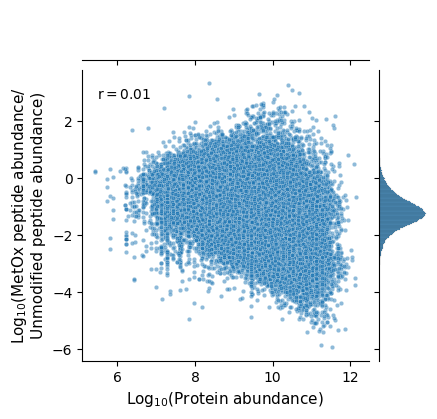

In [ ]:
#fig, ax = plt.subplots(figsize=(4,4))

plot_df.dropna(subset=['Pep/RandSharedPep'], axis=0, inplace=True)

plot_df['log Protein'] = [np.log10(x) for x in plot_df['Protein abundance']]
plot_df['log Ratio'] = [np.log10(x) for x in plot_df['Pep/UnmodifiedPep']]

# 1. Initialize the JointGrid
g = sns.JointGrid(data=plot_df, x="log Protein", y="log Ratio")

# 2. Add the scatterplot to the main (center) ax
g.plot_joint(sns.scatterplot, alpha=0.5, s=10)

# 3. Add the density plot (KDE) to the right margin only
sns.histplot(data=plot_df,y="log Ratio", ax=g.ax_marg_y)

g.fig.set_size_inches(4,4)
g.set_axis_labels(xlabel='Log$_{10}$(Protein abundance)', ylabel='Log$_{10}$(MetOx peptide abundance/\nUnmodified peptide abundance)', fontsize=11)

# compute correlation and annotate plot
prot_abund_list = plot_df['Protein abundance'].to_list()
ratio_list = plot_df['Pep/UnmodifiedPep'].to_list()
nonan_prot = [x for i,x in enumerate(prot_abund_list) if ~np.isnan(x) and ~np.isnan(ratio_list[i])]
nonan_ratio = [x for i,x in enumerate(ratio_list ) if ~np.isnan(x) and ~np.isnan(prot_abund_list[i])]
noinf_prot = [x for i,x in enumerate(prot_abund_list) if ~np.isinf(x) and ~np.isinf(ratio_list[i])]
noinf_ratio = [x for i,x in enumerate(ratio_list ) if ~np.isinf(x) and ~np.isinf(prot_abund_list[i])]
r,p = sp.stats.pearsonr(noinf_prot,noinf_ratio)
g.ax_joint.annotate('r$=$'+str(np.round(r,2)), xy=(0.05,0.9), xycoords='axes fraction')

plt.savefig(outdir+'All_metoxpep_unmod_vs_prot.png', dpi=300, bbox_inches='tight')


In [21]:
r,p = sp.stats.pearsonr(noinf_prot,noinf_ratio)
r,p

(np.float64(0.006130241485086412), np.float64(0.00018662256643357965))

#### Supplementary Figure 10b

In [ ]:
warnings.filterwarnings('ignore')

# generate a dictionary containing the abundance of peptides with alkylated cysteines, the abundances of other peptides from the same protein, and the protein abundance

all_ds_cys_dict = {ds:{} for ds in datasets}

for ds in datasets:
    print(ds)
    print('reading in data')
    data_dir = data_dir_list[datasets.index(ds)]
    samples = samples_list[datasets.index(ds)]

    # all these files are in the analysis dependencies directory
    prot_mainpep_map = pickle.load(open(data_dir+'Main_Proteins_to_Peptides_map.p', 'rb'))
    if ds=='Healthy':
        mainpep_df = pd.read_excel(data_dir+'main_peptide_quant_df.xlsx', index_col=0)
    else:
        mainpep_df = pd.read_excel(data_dir+'main_peptide_precursor_quant_df.xlsx', index_col=0)
    mainpep_df.replace(0,np.nan, inplace=True)
    mainprot_df = pd.read_excel(data_dir+'Main_protein_precursor_quant_df_medianpeptide.xlsx', index_col=0)

    ev_dict = pickle.load(open(data_dir+'DP_search_evidence_dict.p', 'rb'))

    print('making peptide to protein map for tmt sets')
    pep_dict = {s:{row['Sequence']:row['Proteins'] for i,row in s_ev.iterrows()} for s, s_ev in ev_dict.items()}

    # create dict with cysteine-containing peptides, their abundance, and the protein abundance 
    print('generating cys pep dict')
    cys_peps = [x for x in mainpep_df.index.to_list() if 'C' in x]
    cys_dict = {p:{} for p in cys_peps}

    print(len(cys_peps))

    for ip, p in enumerate(cys_peps):
        if ip%10000==0:
            print(ip)

        cys_dict[p]['Abundance'] = {s:np.nan for s in samples}
        cys_dict[p]['Proteins'] = {s:[] for s in samples}
        cys_dict[p]['Medianpep_protein_quant'] = {s:[] for s in samples}
        cys_dict[p]['Mean_medianpep_protein_quant'] = {s:np.nan for s in samples}
        cys_dict[p]['Shared_peptides'] = {s:[] for s in samples}
        cys_dict[p]['Shared_peptide_quant'] = {s:[] for s in samples}
        cys_dict[p]['Mean_shared_peptide_quant'] = {s:np.nan for s in samples}

        for s in samples:
            s_pep_dict = pep_dict[s]
            
            if p in s_pep_dict:
                prots = s_pep_dict[p]
                if isinstance(prots, str):
                    prots = prots.split(';')
                    if isinstance(prots,list) and len(prots)>0:
                        cys_dict[p]['Proteins'][s] = prots
                        cys_dict[p]['Abundance'][s] = mainpep_df.loc[p, s]
                    
                        prot_quant = [float(mainprot_df.loc[prot,s]) if prot in mainprot_df.index else np.nan for prot in prots]
                        cys_dict[p]['Medianpep_protein_quant'][s] = prot_quant
                        cys_dict[p]['Mean_medianpep_protein_quant'][s] = float(np.nanmean(prot_quant))

                        shared_peps_dict = {prot:list(set(prot_mainpep_map[s][prot])) for prot in prots if prot in prot_mainpep_map[s]}
                        n_prots = len(shared_peps_dict)

                        shared_peps_list = [x for y in list(shared_peps_dict.values()) for x in y]
                        shared_peps_count = Counter(shared_peps_list)
                        shared_peps = [x for x in shared_peps_list if shared_peps_count[x] == n_prots]
                        cys_dict[p]['Shared_peptides'][s] = shared_peps

                        shared_pep_quant = [float(mainpep_df.loc[pep,s]) if pep in mainpep_df.index else np.nan for pep in shared_peps]
                        cys_dict[p]['Shared_peptide_quant'][s] = shared_pep_quant
                        cys_dict[p]['Mean_shared_peptide_quant'][s] = float(np.nanmean(shared_pep_quant))
    pickle.dump(cys_dict, open(outdir+ds+'_cysteine_pep_quant_dict.p', 'wb'))
    all_ds_cys_dict[ds] = cys_dict
pickle.dump(all_ds_cys_dict, open(outdir+'Cysteine_pep_quant_dict.p', 'wb'))

In [ ]:
# extract data for dictionary into a dataframe for plotting

plot_rows = []
plot_cols = ['Dataset', 'Sample','Peptide','Peptide abundance', 'Protein abundance', 'Shared peptide abundance', 'Random peptide abundance']#, 'Protein abundance (MaxQuant)']

for ds in datasets:
    samples = samples_list[datasets.index(ds)]
    cys_dict = all_ds_cys_dict[ds]
    for p,pdict in cys_dict.items():
        for s in samples:
            abund = pdict['Abundance'][s]
            if ~np.isnan(abund):
                prot_abund = pdict['Mean_medianpep_protein_quant'][s]
                shared_pep_abund = pdict['Mean_shared_peptide_quant'][s]
                shared_peps = pdict['Shared_peptides'][s]
                notc_peps = [x for x in shared_peps if not 'C' in x]
                # mq_abund = pdict['Mean_MQ_protein_quant'][s]
                if len(notc_peps)>0:
                    rand_sp = random.sample(notc_peps,1)[0]
                    rand_sp_idx = shared_peps.index(rand_sp)
                    rand_sp_abund = pdict['Shared_peptide_quant'][s][rand_sp_idx]
                    if ~np.isnan(prot_abund) and prot_abund!=abund:
                        plot_rows.append([ds, s, p, abund, prot_abund, shared_pep_abund, rand_sp_abund])#, mq_abund])

plot_df = pd.DataFrame(plot_rows, columns=plot_cols)

plot_df['Pep/SharedPep'] = [row['Peptide abundance']/row['Shared peptide abundance'] for i,row in plot_df.iterrows()]
plot_df['Pep/RandSharedPep'] = [row['Peptide abundance']/row['Random peptide abundance'] for i,row in plot_df.iterrows()]

plot_df = pd.read_csv(outdir+'All_cyspep_randSP_vs_prot.csv')

In [ ]:
# plot figure 

plot_df.dropna(subset=['Pep/RandSharedPep'], axis=0, inplace=True)

plot_df['log Protein'] = [np.log10(x) for x in plot_df['Protein abundance']]
plot_df['log Ratio'] = [np.log10(x) for x in plot_df['Pep/RandSharedPep']]

# 1. Initialize the JointGrid
g = sns.JointGrid(data=plot_df, x="log Protein", y="log Ratio")

# 2. Add the scatterplot to the main (center) ax
g.plot_joint(sns.scatterplot, alpha=0.5, s=10)

# 3. Add the density plot (KDE) to the right margin only
sns.histplot(data=plot_df,y="log Ratio", ax=g.ax_marg_y)

g.fig.set_size_inches(4,4)
g.set_axis_labels(xlabel='Log$_{10}$(Protein abundance)', ylabel='Log$_{10}$(Cysteine peptide abundance/\nRandom shared peptide abundance)', fontsize=11)

# compute correlation and annotate plot
r,p = sp.stats.pearsonr(plot_df['Protein abundance'].values, plot_df['Pep/RandSharedPep'].values)
g.ax_joint.annotate('r$=$'+str(np.round(r,2)), xy=(0.05,0.9), xycoords='axes fraction')

plt.savefig(outdir+'All_cyspep_randSP_vs_prot.png', dpi=300, bbox_inches='tight')
